The goal of this notebook is to reassign segmentation labels based on the objects that they are contained in. 
To do so, a hierarchy of objects must first be defined.
# The hierarchy of objects is defined as follows:
- **Cell**
    - **Nucleus**
    - **Cytoplasm**

The index of a given cytoplasm should be the same as that of cell it came from.
The nucleus index should be the same as that of the cell it came from. 

There will also be rules implemented for sandwiched indexes.
This is when an object was not related properly and was assigned a different index while being surrounded (above and below in the z dimension) by the same object.
Such cases will be assigned the same index as the object that is above and below it.


In [1]:
import argparse
import pathlib
import sys

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import skimage
import skimage.io as io
import tifffile
from cellpose import core, models, utils
from rich.pretty import pprint

sys.path.append("../../utils")
import nviz
from nviz.image_meta import extract_z_slice_number_from_filename, generate_ome_xml
from segmentation_decoupling import euclidian_2D_distance

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

In [13]:
if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--patient",
        type=str,
        help="The patient ID",
    )

    parser.add_argument(
        "--well_fov",
        type=str,
        help="Path to the input directory containing the tiff images",
    )
    parser.add_argument(
        "--radius_constraint",
        type=int,
        default=10,
        help="The maximum radius of the x-y vector",
    )
    parser.add_argument(
        "--compartment",
        type=str,
        default="none",
        help="The compartment to segment",
    )

    args = parser.parse_args()
    well_fov = args.well_fov
    x_y_vector_radius_max_constaint = args.radius_constraint
    compartment = args.compartment
    patient = args.patient
else:
    print("Running in a notebook")
    well_fov = "C2-2"
    compartment = "nuclei"
    patient = "NF0014"

mask_dir = pathlib.Path(f"../../data/{patient}/processed_data/{well_fov}").resolve()

Running in a notebook


In [14]:
# get the organoid masks
cell_mask_path = mask_dir / "cell_masks_reconstructed.tiff"
nuclei_mask_path = mask_dir / "nuclei_masks_reconstructed.tiff"
cell_mask = io.imread(cell_mask_path)
nuclei_mask = io.imread(nuclei_mask_path)

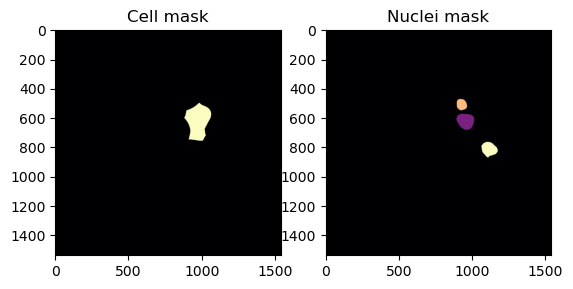

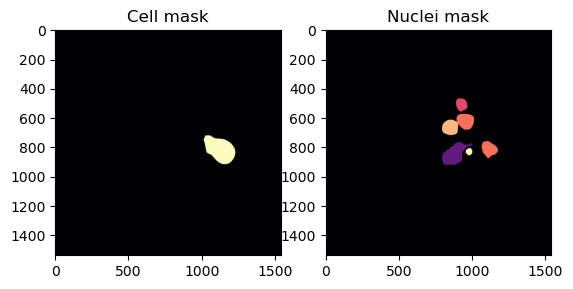

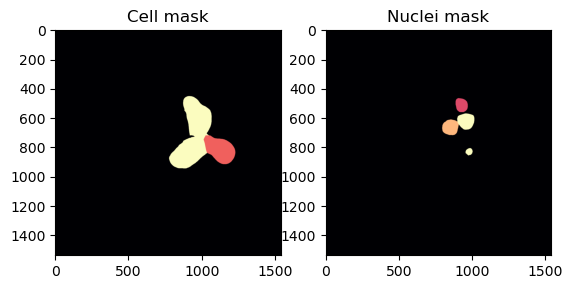

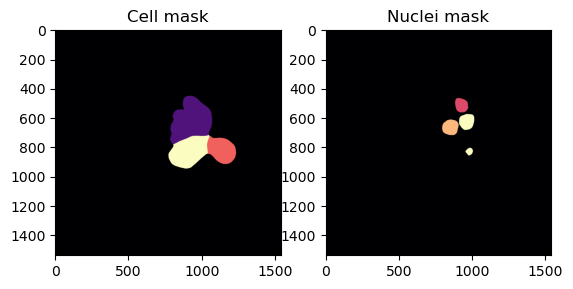

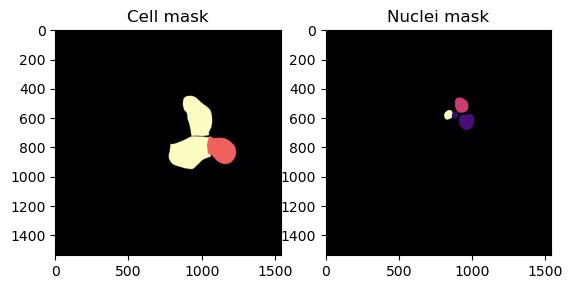

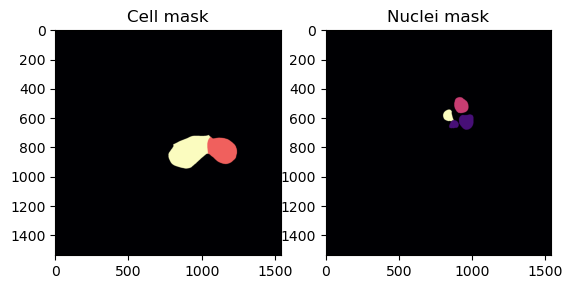

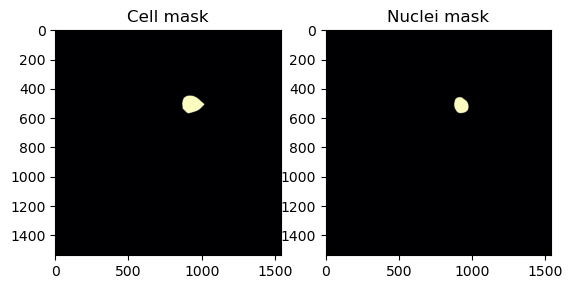

In [26]:
# get the first z slice of the image
for z in range(cell_mask.shape[0]):
    plt.subplot(1, 2, 1)
    plt.imshow(cell_mask[z, :, :], cmap="magma")
    plt.title("Cell mask")
    plt.subplot(1, 2, 2)
    plt.imshow(nuclei_mask[z, :, :], cmap="magma")
    plt.title("Nuclei mask")
    plt.show()

In [23]:
# get the centroid and bbox of the cell mask
cell_df = pd.DataFrame.from_dict(
    skimage.measure.regionprops_table(
        cell_mask,
        properties=["centroid", "bbox"],
    )
)
cell_df["compartment"] = "cell"
cell_df["label"] = cell_mask[
    cell_df["centroid-0"].astype(int),
    cell_df["centroid-1"].astype(int),
    cell_df["centroid-2"].astype(int),
]
cell_df

,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,compartment,label
0,6.000000,510.940809,931.830488,6,453,867,7,573,1019,cell,2
1,2.018573,623.667401,941.665103,0,454,785,4,784,1071,cell,12
2,2.994628,821.016791,1130.890022,1,721,1013,6,919,1240,cell,8
3,3.390516,761.518940,930.520449,2,454,773,6,953,1071,cell,12


In [24]:
nuclei_df = pd.DataFrame.from_dict(
    skimage.measure.regionprops_table(
        nuclei_mask,
        properties=["centroid", "bbox"],
    )
)
nuclei_df["compartment"] = "nuclei"
nuclei_df["label"] = nuclei_mask[
    nuclei_df["centroid-0"].astype(int),
    nuclei_df["centroid-1"].astype(int),
    nuclei_df["centroid-2"].astype(int),
]
nuclei_df

,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,compartment,label
0,4.000000,585.170072,878.632812,4,562,857,5,608,901,nuclei,4
1,3.027276,629.947184,947.347970,0,576,839,6,688,1010,nuclei,20
2,1.000000,850.123517,874.255021,1,769,791,2,926,998,nuclei,6
3,3.390104,517.015196,921.935767,0,463,874,7,572,971,nuclei,12
4,0.698681,744.829870,1050.787614,0,576,888,2,879,1172,nuclei,0
5,1.999895,668.526514,847.486037,1,615,790,4,723,904,nuclei,17
6,2.376855,671.958078,960.363355,1,574,893,4,861,1011,nuclei,20
7,4.589523,586.285101,832.413053,4,547,798,6,627,870,nuclei,22


In [ ]:
# if a centroid of the nuclei is inside the cell mask,
# then make the cell retain the label of the nuclei